# Adversarial Example Creation - FGSM (CIFAR10)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# BUG FIX, see: https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Load libs
import torch
import torch.nn as nn
from torch.nn.functional import adaptive_avg_pool2d
from torch.utils.data import TensorDataset
import torchvision
from torchvision import transforms
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import skimage
from skimage.measure import block_reduce
from umap import UMAP
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import platform
import warnings
import pprint
from collections import Counter

sns.set()
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('skimage version:     {}'.format(skimage.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('seaborn version:     {}'.format(sns.__version__))
print('pandas version:      {}'.format(pd.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))
    
if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
sklearn version:     0.23.2
skimage version:     0.17.2
numpy version:       1.19.5
matplotlib version:  3.2.2
seaborn version:     0.11.0
pandas version:      1.1.4
pickle version:      4.0
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


Put CUDNN to deterministic and set seed values for [reproducibility reasons](https://pytorch.org/docs/stable/notes/randomness.html).

In [2]:
random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

Let's set some parameters for the Deep kNN.

In [3]:
batch_size_train = 500    # batch size for training
batch_size_test = 1000    # batch size for testing

## Data

### Specify Dataset

Define data transform functions for training and test set.

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

Define training and test set.

In [5]:
# Training set
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)

# Test set and calibration set
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


### Load Data

Create train, test and calibration data loader.

In [6]:
# Create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=False, num_workers=2
)

# Create test data loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=2
)

Print out the sizes of the datasets.

In [7]:
print('trainset size: {}'.format(len(trainloader.dataset)))
print('testset size:  {}'.format(len(testloader.dataset)))

trainset size: 50000
testset size:  10000


### Display Samples

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()

        img = data[i]
        img[0] = img[0] * 0.2023 + 0.4914
        img[1] = img[1] * 0.1994 + 0.4822
        img[2] = img[2] * 0.2010 + 0.4465
        img = np.clip(img, 0, 1)
        img = np.moveaxis(img, 0, -1)
        
        plt.imshow(img)
        plt.title("Ground Truth: {}".format(classes[targets[i]]))
        
        plt.xticks([])
        plt.yticks([])

Load a few test images and display them.

tensor shape: (1000, 3, 32, 32)


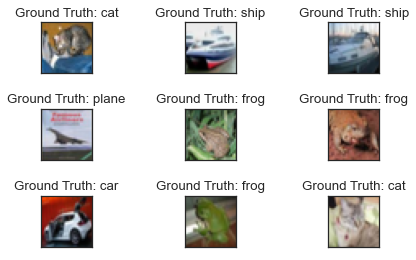

In [9]:
dataiter = enumerate(testloader)
_, (sample_data, sample_targets) = next(dataiter)

show_samples(sample_data, sample_targets)

## Define Test Functions

Let's define the function for testing.

In [10]:
def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in data_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

## Network Architecture

Let's define the neural network based model architecture for Fixup-ResNet-20.

In [11]:
def mixup_data(x, y, alpha=1.0, use_cuda=True, per_sample=False):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    if alpha > 0. and not per_sample:
        lam = torch.zeros(y.size()).fill_(np.random.beta(alpha, alpha)).cuda()
        mixed_x = lam.view(-1, 1, 1, 1) * x + (1 - lam.view(-1, 1, 1, 1)) * x[index,:]
    elif alpha > 0.:
        lam = torch.Tensor(np.random.beta(alpha, alpha, size=y.size())).cuda()
        mixed_x = lam.view(-1, 1, 1, 1) * x + (1 - lam.view(-1, 1, 1, 1)) * x[index,:]
    else:
        lam = torch.ones(y.size()).cuda()
        mixed_x = x

    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_lam_idx(batch_size, alpha, use_cuda=True):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    return lam, index    


def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: criterion(pred, y_a, lam) + criterion(pred, y_b, 1 - lam)


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std


def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

                
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class FixupBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(FixupBasicBlock, self).__init__()
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.bias1a = nn.Parameter(torch.zeros(1))
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bias1b = nn.Parameter(torch.zeros(1))
        self.relu = nn.ReLU(inplace=True)
        self.bias2a = nn.Parameter(torch.zeros(1))
        self.conv2 = conv3x3(planes, planes)
        self.scale = nn.Parameter(torch.ones(1))
        self.bias2b = nn.Parameter(torch.zeros(1))
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x + self.bias1a)
        out = self.relu(out + self.bias1b)

        out = self.conv2(out + self.bias2a)
        out = out * self.scale + self.bias2b

        if self.downsample is not None:
            identity = self.downsample(x + self.bias1a)
            identity = torch.cat((identity, torch.zeros_like(identity)), 1)

        out += identity
        out = self.relu(out)

        return out


class FixupResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        super(FixupResNet, self).__init__()
        self.num_layers = sum(layers)
        self.inplanes = 16
        self.conv1 = conv3x3(3, 16)
        self.bias1 = nn.Parameter(torch.zeros(1))
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.bias2 = nn.Parameter(torch.zeros(1))
        self.fc = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, FixupBasicBlock):
                nn.init.normal_(m.conv1.weight, mean=0, std=np.sqrt(2 / (m.conv1.weight.shape[0] * np.prod(m.conv1.weight.shape[2:]))) * self.num_layers ** (-0.5))
                nn.init.constant_(m.conv2.weight, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.weight, 0)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.AvgPool2d(1, stride=stride)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x + self.bias1)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x + self.bias2)

        return x


def fixup_resnet20(**kwargs):
    """Constructs a Fixup-ResNet-20 model.
    """
    model = FixupResNet(FixupBasicBlock, [3, 3, 3], **kwargs)
    return model

## Model Testing

Let's load the model.

In [12]:
# Create Model
model = fixup_resnet20()
cel = nn.CrossEntropyLoss()

# Load Model
model.load_state_dict(torch.load("/Users/lehmann/research/laca/models/cifar10_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

Put model in evaluation mode.

In [13]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

Let's test the model.

In [14]:
def test_final(model, data_loader):
    _, accs = test(model, cel, data_loader, [], [])
    return accs[0]

In [15]:
test_acc = test_final(model, testloader); test_acc


Test set: Avg. loss: 0.000297, Accuracy: 9247/10000 (92.47%)



92.47

## Create Adversarial Examples

In [16]:
class CustomTensorDataset(torch.utils.data.Dataset):
    """
    TensorDataset with support for transforms
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


def fgsm_attack(image, epsilon, data_grad, normalized=True):
    # If image is normalized, denormalize with MNIST statistics
    if normalized:
        image[0,0] = image[0,0] * 0.2023 + 0.4914
        image[0,1] = image[0,1] * 0.1994 + 0.4822
        image[0,2] = image[0,2] * 0.2010 + 0.4465
        #image = np.clip(image, 0, 1)

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # If image should be normalized, normalize with MNIST statistics
    if normalized:
        perturbed_image[0,0] = (perturbed_image[0,0] - 0.4914) / 0.2023 
        perturbed_image[0,1] = (perturbed_image[0,1] - 0.4822) / 0.1994
        perturbed_image[0,2] = (perturbed_image[0,2] - 0.4465) / 0.2010

    # Return the perturbed image
    return perturbed_image


def create_adversarials(model, dataloader, epsilon):
    adv_examples = []
    targets = []
    init_preds = []
    final_preds = []

    # Loop over all examples in data set
    for data, target in dataloader:

        # If we run on GPU, send data and target to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = cel(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Save adversarial examples
        adv_ex = perturbed_data.detach().cpu().numpy()
        adv_examples.append(adv_ex)
        targets.append(target.item())
        init_preds.append(init_pred.item())
        final_preds.append(final_pred.item())

    # Return the accuracy and an adversarial example
    result = {
        'adv_examples': np.vstack(adv_examples),
        'targets': targets,
        'init_preds': np.array(init_preds),
        'final_preds': np.array(final_preds)
    }
    return result

In [17]:
eps = 0.1

# Create test data loader for adversarial creation (batch size needs to be 1)
testloader_adv = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=2
)

print('testset size:  {}'.format(len(testloader.dataset)))
print()

# Create adversarials
print('## Creating adversarials with epsilon = {}'.format(eps))

adversarials = create_adversarials(model, testloader_adv, eps)
print('adversarials created')

# Make dataloader from created adversarials
adv_data = torch.FloatTensor(adversarials['adv_examples'])
adv_targets = torch.LongTensor(adversarials['targets'])

advdataset = CustomTensorDataset(tensors=(adv_data, adv_targets), transform=None)
advloader = torch.utils.data.DataLoader(
    advdataset, batch_size=batch_size_test, shuffle=False, num_workers=2
)
print('advset size: {}'.format(len(advloader.dataset)))

# Test created adversarial set against our model
acc = test_final(model, advloader)
print('test accuracy: {}'.format(acc))
print()

print('done!')

testset size:  10000

## Creating adversarials with epsilon = 0.1
adversarials created
advset size: 10000

Test set: Avg. loss: 0.003418, Accuracy: 1321/10000 (13.21%)

test accuracy: 13.21

done!


tensor shape: (1000, 3, 32, 32)


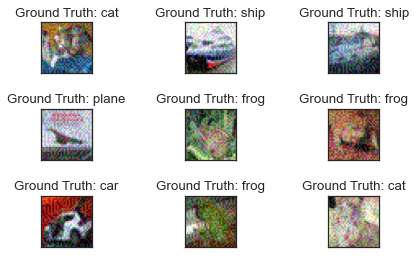

In [18]:
dataiter = enumerate(advloader)
_, (adv_data, adv_targets) = next(dataiter)

show_samples(adv_data, adv_targets)

In [19]:
fname = '/Users/lehmann/research/laca/adv_examples/advloader_cifar10_fgsm.pth'
torch.save(advloader, fname)

In [20]:
loaded_advloader = torch.load(fname)

In [21]:
acc = test_final(model, loaded_advloader)
print('advset size: {}'.format(len(loaded_advloader.dataset)))
print('test accuracy: {}'.format(acc))


Test set: Avg. loss: 0.003418, Accuracy: 1321/10000 (13.21%)

advset size: 10000
test accuracy: 13.21


tensor shape: (1000, 3, 32, 32)


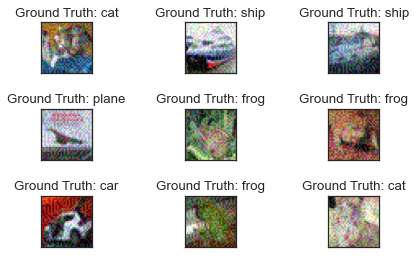

In [22]:
dataiter = enumerate(loaded_advloader)
_, (adv_data, adv_targets) = next(dataiter)

show_samples(adv_data, adv_targets)